In [15]:
import os, shutil
train_dir = '../train'
validation_dir = '../validation'
test_dir = '../test'

In [16]:
from keras.utils import image_dataset_from_directory

IMG_SIZE = 32

train_dataset = image_dataset_from_directory(train_dir,label_mode='categorical',image_size=(IMG_SIZE, IMG_SIZE))
validation_dataset = image_dataset_from_directory(validation_dir,label_mode='categorical',image_size=(IMG_SIZE, IMG_SIZE))
test_dataset = image_dataset_from_directory(test_dir,label_mode='categorical',image_size=(IMG_SIZE, IMG_SIZE))

Found 40000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.


In [71]:
import ssl
import requests

requests.packages.urllib3.disable_warnings()
ssl._create_default_https_context = ssl._create_unverified_context
response = requests.get('https://storage.googleapis.com/tensorflow/keras-applications/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

from tensorflow.keras.applications.vgg19 import VGG19

conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
conv_base.trainable = False

In [72]:
from tensorflow import keras
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg19.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

In [73]:
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 81ms/step


In [74]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [75]:
from tensorflow import keras
from keras import layers
from tensorflow.keras.regularizers import l2

inputs = keras.Input(shape=(1, 1, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs, outputs)

In [76]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(loss='categorical_crossentropy',optimizer=optimizers.SGD(learning_rate=1e-4),metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

history = model.fit(train_features, train_labels,epochs=80, batch_size=32, validation_data=(val_features, val_labels),callbacks=[early_stopping])

Epoch 1/80
1250/1250 [==============================] - 4s 3ms/step - loss: 3.6835 - accuracy: 0.1626 - val_loss: 2.7079 - val_accuracy: 0.2757
Epoch 2/80
1250/1250 [==============================] - 3s 3ms/step - loss: 3.1467 - accuracy: 0.2455 - val_loss: 2.4031 - val_accuracy: 0.3727
Epoch 3/80
1250/1250 [==============================] - 3s 3ms/step - loss: 2.8732 - accuracy: 0.3082 - val_loss: 2.2395 - val_accuracy: 0.4244
Epoch 4/80
1250/1250 [==============================] - 3s 2ms/step - loss: 2.7152 - accuracy: 0.3419 - val_loss: 2.1466 - val_accuracy: 0.4539
Epoch 5/80
1250/1250 [==============================] - 3s 2ms/step - loss: 2.6022 - accuracy: 0.3704 - val_loss: 2.0710 - val_accuracy: 0.4782
Epoch 6/80
1250/1250 [==============================] - 3s 2ms/step - loss: 2.5244 - accuracy: 0.3906 - val_loss: 2.0160 - val_accuracy: 0.4919
Epoch 7/80
1250/1250 [==============================] - 3s 2ms/step - loss: 2.4683 - accuracy: 0.4022 - val_loss: 1.9770 - val_accuracy:

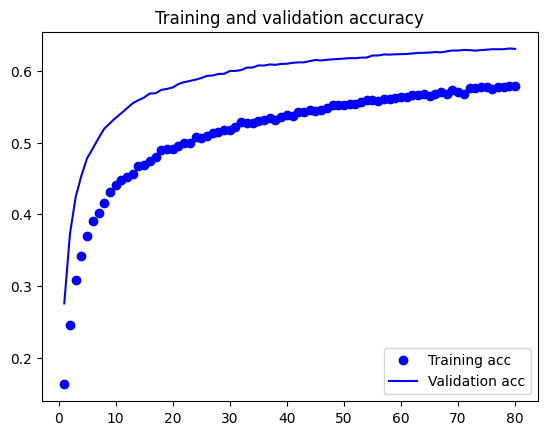

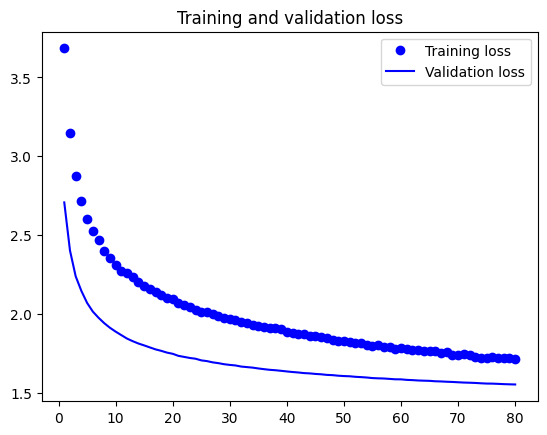

In [77]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc,'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss,'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [29]:
from keras import models
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = keras.applications.vgg19.preprocess_input(inputs) 
x = conv_base(x)
outputs = model(x)
full_model = keras.Model(inputs, outputs)

In [30]:
full_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),metrics=['accuracy'])

In [46]:
#full_model.save('ModelT_transferLearning_featureExtraction_WithoutDataAumentation')

INFO:tensorflow:Assets written to: ModelT_transferLearning_featureExtraction_WithoutDataAumentation/assets


INFO:tensorflow:Assets written to: ModelT_transferLearning_featureExtraction_WithoutDataAumentation/assets


In [31]:
from tensorflow import keras

loaded_model = keras.models.load_model('ModelT_transferLearning_featureExtraction_WithoutDataAumentation')

val_loss, val_acc = loaded_model.evaluate(validation_dataset) 
print('val_acc:', val_acc)

313/313 [==============================] - 35s 112ms/step - loss: 1.7637 - accuracy: 0.7031
val_acc: 0.7031000256538391
